<a href="https://colab.research.google.com/github/raplima/2020_cores_auto/blob/master/scripts/eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone repository
!git clone https://github.com/raplima/2020_cores_auto.git

fatal: destination path '2020_cores_auto' already exists and is not an empty directory.


In [2]:
import os

import json
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
# count the instances
data_dir = '/content/2020_cores_auto/data'
folds_jsons = sorted(ii for ii in os.listdir(data_dir) if 'fold' in ii)

print(f'{"fold":8s} {"dset":9} {" #figures":10s} {" #instances":16s}')
for ii in folds_jsons:
    # read the metrics json file
    json_file = os.path.join(data_dir, ii)
    with open(json_file) as f:
        folds_dict = json.load(f)
    instances_in = sum(len(folds_dict[k]['regions']) for k in folds_dict.keys())
    fold = ii.split("_")[2]
    dset = ii.split("_")[3].split('.')[0]
    print(f'{fold:8s} {dset:8s} {len(folds_dict):10d} {instances_in:12}')


fold     dset       #figures   #instances     
0        train            56          543
0        val              15          113
1        train            57          493
1        val              14          163
2        train            57          551
2        val              14          105
3        train            57          543
3        val              14          113
4        train            57          494
4        val              14          162


In [4]:
# list the folders
#results_dir = '/content/2020_cores_auto/data/results/R50-C4'
#out_folders = sorted(os.listdir(results_dir))

results_root = '/content/2020_cores_auto/data/results/'

dfs = {}
dfs_ap = {}
for dir in os.listdir(results_root):
    results_dir = os.path.join(results_root, dir)
    out_folders = sorted(os.listdir(results_dir))

    # create dataframe
    metrics = []
    for dd in out_folders:
        fold = dd.split('_')[-1]
        # read the metrics json file
        json_file = os.path.join(results_dir, dd, 'metrics.json')
        with open(json_file) as f:
            for line in f:
                metrics.append(json.loads(line)) 
                metrics[-1]['fold'] = fold
                # clean up cores_fold_{fold}_train/ and cores_fold_{fold}_val/
                keys_to_clean = [k for k in metrics[-1] if 'cores_fold' in k]
                for k in keys_to_clean:
                    new_key = k.split('_', -1)[-1]
                    metrics[-1][new_key] = metrics[-1].pop(k)
    df = pd.DataFrame(metrics)                
    dfs[dir] = df.copy()

    # create the AP metrics dataframe (this is very similar to the above)
    # be careful with repeated variables:
    metrics = []
    for dd in out_folders:
        fold = dd.split('_')[-1]
        for dset in ['train', 'val']:
            # read the metrics json file
            json_file = os.path.join(results_dir, dd, f'cocoeval_{dset}_{fold}.json')
            with open(json_file) as f:
                metrics.append(json.load(f)['segm']) 
            metrics[-1]['fold'] = fold
            metrics[-1]['set'] = dset
    df = pd.DataFrame(metrics)      
    df = df.drop(labels=['APs', 'APm', 'APl'], axis=1)      
    dfs_ap[dir] = df.copy()


# list of experiments/dictionary keys
exps = ['R50-C4', 'R50-FPN']
models = ['ResNet50', 'ResNet50-FPN']
for exp, mod in zip(exps, models):
    dfs[exp]['Model'] = mod
    dfs_ap[exp]['Model'] = mod
# combine dfs into a single one
df = pd.concat(dfs, ignore_index=True)
df_ap = pd.concat(dfs_ap, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


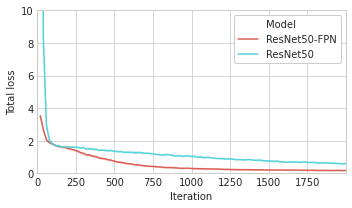

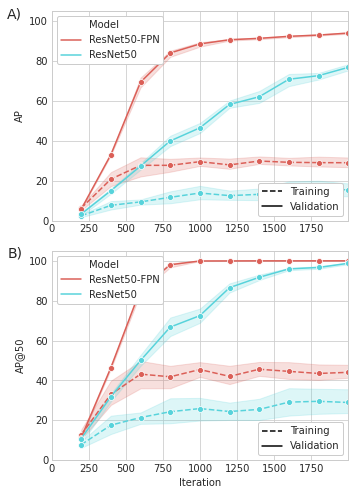

In [5]:
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

with plt.style.context('seaborn-whitegrid'):
    rcParams['font.sans-serif'] = ['Tahoma']
    rcParams['legend.framealpha'] = 1.0
    rcParams['legend.frameon'] = True
    palette = sns.color_palette("hls", len(df['Model'].unique()))
    
    # first fig
    fig, ax = plt.subplots(ncols=1, figsize=(5,3))
    sns.lineplot(x="iteration", y="total_loss", hue='Model', palette=palette, 
                data=df,
                ax=ax)
    ax.set_xlim(0,np.max(df['iteration']))
    ax.set_ylim(0,10)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Total loss')

    fig.tight_layout()
    fig.savefig('/content/training_loss.pdf')

    ############################################################################
    ############################################################################
    # second fig
    fig, ax = plt.subplots(2, figsize=(5,7))
    sns.lineplot(x="iteration", y="val/segm/AP", hue='Model', 
                 marker='o', palette=palette,
                 data=df, ax=ax[0])  

    sns.lineplot(x="iteration", y="val/segm/AP50", hue='Model', 
                 marker='o', palette=palette,
                 data=df, ax=ax[1])
    
    # change the dashes:
    [ax[0].lines[ii].set_linestyle("--") for ii, _ in enumerate(ax[0].lines)]    
    [ax[1].lines[ii].set_linestyle("--") for ii, _ in enumerate(ax[1].lines)]        

    sns.lineplot(x="iteration", y="train/segm/AP", hue='Model', 
                 marker='o', palette=palette, 
                 legend=False, 
                 data=df, ax=ax[0])
    ax[0].set_xlabel('')
    ax[0].set_ylabel('AP')
    ax[0].set_xlim(0,np.max(df['iteration']))    
    ax[0].set_ylim(0,105) 

    sns.lineplot(x="iteration", y="train/segm/AP50", hue='Model', 
                 marker='o', palette=palette, 
                 legend=False,
                 data=df, ax=ax[1])
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('AP@50')
    ax[1].set_xlim(0,np.max(df['iteration'])) 
    ax[1].set_ylim(0,105) 

    # get the legend for the plotted lines.
    first_legends = [ax[ii].get_legend() for ii in range(len(ax))]
    # Add the legend manually to the current Axes.
    for ii, first_legend in enumerate(first_legends): 
        ax[ii].add_artist(first_legend)

    # set training/validation legend
    custom_lines = [Line2D([0], [0], color='k', ls="--"),
            Line2D([0], [0], color='k', ls="-")]
    for ii in range(len(ax)): 
        ax[ii].legend(custom_lines, ['Training', 'Validation'], loc='lower right') 

    # add letters:
    for ii, l in enumerate(['A)', 'B)']):
        ax[ii].text(-300, 100,
                    s=l, 
                    bbox=dict(facecolor='white', edgecolor='white', alpha=1), 
                    ha='left', va='bottom', size=14)
    
    fig.tight_layout()
    fig.savefig('/content/training_aps.pdf')

In [6]:
# create dataframe
metrics = []
for dd in out_folders:
    fold = dd.split('_')[-1]
    for dset in ['train', 'val']:
        # read the metrics json file
        json_file = os.path.join(results_dir, dd, f'cocoeval_{dset}_{fold}.json')
        with open(json_file) as f:
            metrics.append(json.load(f)['segm']) 
        metrics[-1]['fold'] = fold
        metrics[-1]['set'] = dset
df = pd.DataFrame(metrics)      
df = df.drop(labels=['APs', 'APm', 'APl'], axis=1)      

In [7]:
df_ap.groupby(['Model', 'set']).describe()[['AP', 'AP75', 'AP50']].T

Model        ResNet50            ResNet50-FPN           
set             train        val        train        val
AP   count   5.000000   5.000000     5.000000   5.000000
     mean   76.838922  15.445938    94.013718  29.046451
     std     2.021833   4.262126     0.521930   2.985862
     min    74.047342   9.822572    93.559688  25.675847
     25%    75.400809  13.021208    93.661987  28.174086
     50%    77.667941  15.930756    93.872087  28.601558
     75%    78.437828  17.449276    94.105998  28.905072
     max    78.640693  21.005876    94.868828  33.875692
AP75 count   5.000000   5.000000     5.000000   5.000000
     mean   92.107322  15.354107    99.972245  30.717381
     std     1.724482   4.359424     0.032296   5.203952
     min    90.326583   8.841097    99.922033  26.201539
     25%    90.419063  12.934727    99.959440  28.344977
     50%    92.172187  17.476979    99.982986  29.122693
     75%    93.614678  18.594165    99.996767  30.280163
     max    94.004102  18.923566   100.000000  39.637535
AP50 count   5.000000   5.000000     5.000000   5.000000
     mean   98.717895  28.978689    99.972245  44.084795
     std     0.555983   7.260610     0.032296   4.257121
     min    97.814049  19.746759    99.922033  40.954894
     25%    98.610628  26.304073    99.959440  41.119084
     50%    98.904699  28.019463    99.982986  42.619043
     75%    99.000856  31.240273    99.996767  44.462167
     max    99.259245  39.582879   100.000000  51.268789

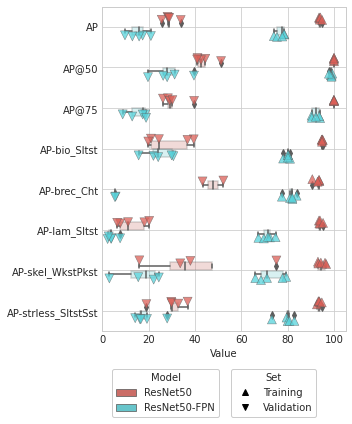

In [9]:
# "Melt" the dataset to "long-form" or "tidy" representation
melted = pd.melt(df_ap, ["Model", "set", "fold"])
melted = melted.replace('AP50', 'AP@50')
melted = melted.replace('AP75', 'AP@75')

with plt.style.context('seaborn-whitegrid'):    
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Tahoma']
    rcParams['legend.framealpha'] = 1.0
    rcParams['legend.frameon'] = True
    # first fig
    fig, ax = plt.subplots(1, figsize=(5,6))

    for dset, mark in zip(['train', 'val'], ['^', 'v']):
        sns.boxplot(x="value", y="variable", hue="Model",
                    dodge=True, width=0.4, palette=palette,
                    data=melted.loc[melted['set'] == dset], 
                    boxprops=dict(alpha=.25),
                    ax=ax)

    # Show each observation with a scatterplot
        sns.stripplot(x="value", y="variable", hue="Model", 
                      marker = mark,
                    linewidth=0.5, size=9, palette=palette,
                    data=melted.loc[melted['set'] == dset], 
                    dodge=True, 
                     alpha=.75,
                    ax=ax)
    
    ax.set_xlabel('Value')
    ax.set_xlim(0, 105)
    ax.set_ylabel('')
    ax.grid(True)

    # Improve the legend 
    handles, labels = ax.get_legend_handles_labels()
    box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width, box.height*0.85])
    
    legend_x = 0.5
    legend_y = -0.1
    
    leg1 = ax.legend(handles=handles[:3], labels=models, 
              bbox_to_anchor=(legend_x, legend_y),
              title="Model")

    legend_x = 0.9
    legend_y = -0.1

    custom_lines = [Line2D([0], [0], color='k', ls='None', marker='^'),
                    Line2D([0], [0], color='k', ls='None', marker='v')]
    ax.legend(custom_lines, ['Training', 'Validation'], 
              bbox_to_anchor=(legend_x, legend_y),
              title='Set')
    
    ax.add_artist(leg1)

    fig.tight_layout()
    fig.savefig('/content/aps.pdf')